In [1]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

In [2]:
from core.cluster_validation import generate_neigbhourhood_groups, colored_crosstab
from core.utils import used_keys

In [3]:
import umap
import umap.plot
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

In [4]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"

In [5]:
# region_id = 4182

# tessellations_dir = graph_dir = '../data/ms_buildings/'
# chars_dir = '../data/ms_buildings/chars/'

In [6]:
region_id = 'freiburg'

tessellations_dir = graph_dir = '../data/freiburg//'
chars_dir = '../data/freiburg/chars/'

In [7]:
spatial_lag = 3


X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')
# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')
lag = pd.read_parquet(f'../data/freiburg/chars/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')

# X_train = X_train.join(lag[[c for c in lag.columns if '_median' in c]], how='inner')
X_train = X_train.join(lag, how='inner')

X_train.shape

(36727, 248)

In [8]:
X_train = X_train[X_train.index >= 0]


vals = np.nan_to_num(StandardScaler().fit_transform(X_train))
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
# X_train = X_train.clip(-10, 10)

vals = np.nan_to_num(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

In [9]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)
tessellation = tessellation[tessellation.index.isin(X_train.index)]

In [10]:
# X_train = pd.read_parquet('../data/old_prague_data/old_prague_data.parquet')
# X_train = X_train.set_index('uID').sort_index()
# tessellation = gpd.read_file('../data/old_prague_data/prg_geometry.gpkg', 
#                              layer='tessellation').set_index('uID').sort_index().to_crs(epsg=3035)

# vals = np.nan_to_num(StandardScaler().fit_transform(X_train))
# X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
# # X_train = X_train.clip(-10, 10)

# vals = np.nan_to_num(X_train)
# X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

In [11]:
tess_groups = generate_neigbhourhood_groups(tessellation, 
                                         include_random_sample=True,
                                         random_sample_size=1_000)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [12]:
# tessellation.loc[tess_groups.index].explore()

In [13]:
from core.cluster_validation import print_distance
print_distance( pd.DataFrame(X_train.loc[tess_groups.index]).groupby(tess_groups.values).mean(), metric='euclidean')

,random
random,0.000000


In [14]:
def show_nn(n_neighbors, n_components, n_epochs, min_dist):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        n_epochs=n_epochs,
    )
    embedding = reducer.fit_transform(X_train.iloc[tess_groups_ilocs])

    embedding_df = pd.DataFrame(embedding, index=tess_groups.index)
    embedding_df["neighbourhood"] = tess_groups.values

    print(
        n_neighbors,
        n_components,
        n_epochs,
        min_dist,
        "--",
        davies_bouldin_score(embedding, tess_groups.values),
    )

    if n_components == 2:
        return umap.plot.points(reducer, labels=tess_groups.values)
    else:
        return None

In [ ]:
for n_neighbors in [15, 25, 50, 100]:
    show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.0)

In [15]:
data = X_train.values

In [16]:
n_neighbors = 25
negative_sample_rate = n_neighbors
n_epochs = 5000

noise_level = .5
learning_rate = 1

neighbor_scale = 1.0
symmetrize_graph = True
node_embedding_dim = 2

In [17]:
### need to compute knn + 1, and then pass the results[1:], there is an issue with the evoc functions - numerical maybe
### the nndescent approximation gets the relative density of the nearest neighbours correct compared to real distances
### should try to initialise this graph somehow differently based on contiguity - immidiate spatial neighbours are 1s, other neighbours are based on knn similarity

In [18]:
from evoc.knn_graph import knn_graph
from evoc.graph_construction import neighbor_graph_matrix, smooth_knn_dist, compute_membership_strengths

/home/krasen/evoc/evoc/float_nndescent.py:287: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  points = point_indices[i]


In [19]:
%%time
nn_inds, nn_dists = knn_graph(data, n_neighbors=n_neighbors+1)

CPU times: user 8.32 s, sys: 185 ms, total: 8.5 s
Wall time: 1.53 s


In [20]:
%%time

graph = neighbor_graph_matrix(
    neighbor_scale * n_neighbors, nn_inds[:, 1:], nn_dists[:, 1:], symmetrize_graph
)

CPU times: user 212 ms, sys: 11.2 ms, total: 223 ms
Wall time: 85.6 ms


In [21]:
from evoc.label_propagation import label_propagation_init

In [22]:
%%time
init_embedding = label_propagation_init(
            graph,
            n_components=node_embedding_dim,
            approx_n_parts=np.clip(int(np.sqrt(data.shape[0])), 100, 1024),
            random_scale=0.1,
            scaling=0.5,
            noise_level=noise_level,
        )

CPU times: user 1.21 s, sys: 10.2 ms, total: 1.22 s
Wall time: 89.1 ms


In [23]:
from evoc.node_embedding import node_embedding

In [24]:
graph = graph.tocoo()

In [25]:
%%time
embedding = node_embedding(
        graph,
        n_components=node_embedding_dim,
        n_epochs=n_epochs,
        initial_embedding=init_embedding,
        negative_sample_rate=negative_sample_rate,
        noise_level=noise_level,
        verbose=True,
    )

/home/krasen/evoc/evoc/node_embedding.py:13: RuntimeWarning: overflow encountered in divide
  result[n_samples > 0] = float(n_epochs) / np.float32(n_samples[n_samples > 0])


CPU times: user 45.4 s, sys: 247 ms, total: 45.6 s
Wall time: 2.84 s


In [27]:
def plot_datashade_umap(embedding, labels=None, n_neighbors=0.0, min_dist=0.0):
    class MockEmbedding(object):
        pass
    
    enb = MockEmbedding()
    enb.embedding = embedding
    enb.n_neighbors = n_neighbors
    enb.min_dist = 0.0

    if labels is None:
        return umap.plot.points(enb)
    
    return umap.plot.points(enb, labels=labels)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


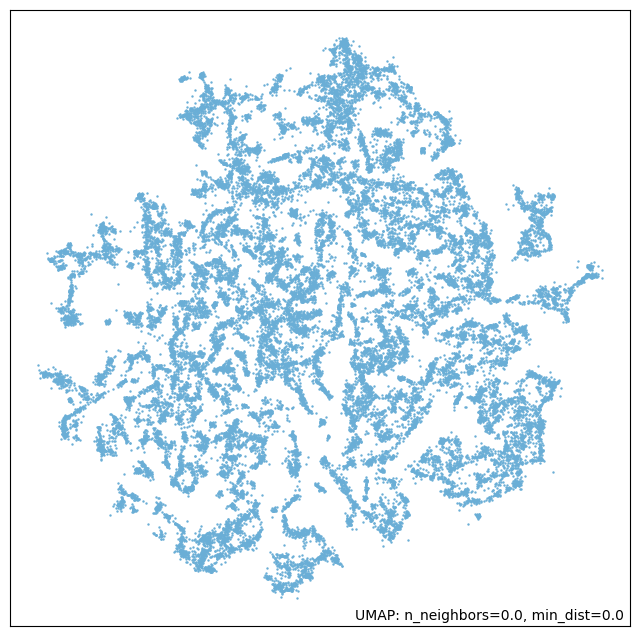

In [30]:
if node_embedding_dim == 2:
    plot_datashade_umap(embedding[tess_groups_ilocs], tess_groups.values)

In [32]:
davies_bouldin_score(
    embedding[tess_groups_ilocs], 
    tess_groups.values
)

In [ ]:
# x, y = tessellation.loc[tess_groups.index].representative_point().x.values, tessellation.loc[tess_groups.index].representative_point().y.values

In [ ]:
rps = tessellation[tessellation.index.isin(X_train.index)].representative_point()
x, y = rps.x.values, rps.y.values

In [ ]:
spatial_init = np.vstack((x,y)).T
spatial_init = StandardScaler().fit_transform(spatial_init)
spatial_init = np.ascontiguousarray(spatial_init, dtype=np.float32)

In [ ]:
plot_datashade_umap(spatial_init[tess_groups_ilocs], tess_groups.values)

In [ ]:
# negative_sample_rate = 50
# noise_level = .01
# n_epochs = 10000

In [ ]:
new_spatial_init = spatial_init
new_node_embedding_dim = node_embedding_dim

In [ ]:
# new_node_embedding_dim = 5
# new_spatial_init = np.ascontiguousarray(np.hstack((spatial_init,
#                                                    np.random.randn(spatial_init.shape[0], new_node_embedding_dim - 2))), 
#                                         dtype=np.float32)
# new_spatial_init

In [ ]:
# new_node_embedding_dim = spatial_init.shape[1] + init_embedding.shape[1]
# new_spatial_init = np.ascontiguousarray(np.hstack((spatial_init, init_embedding)), 
#                                         dtype=np.float32)
# new_spatial_init

In [ ]:
%%time
spatial_embedding = node_embedding(
        graph,
        n_components=new_node_embedding_dim,
        n_epochs=n_epochs,
        initial_embedding=new_spatial_init,
        negative_sample_rate=negative_sample_rate,
        noise_level=noise_level,
        initial_alpha=learning_rate,
        verbose=False,
    )

In [ ]:
spatial_embedding

In [ ]:
plot_datashade_umap(spatial_embedding[tess_groups_ilocs], tess_groups.values)

In [ ]:
plot_datashade_umap(spatial_embedding)

In [ ]:
plot_datashade_umap(embedding)

In [ ]:
davies_bouldin_score(
    spatial_embedding[tess_groups_ilocs], 
    tess_groups.values
), davies_bouldin_score(
    embedding[tess_groups_ilocs], 
    tess_groups.values
)

In [ ]:
print_distance( pd.DataFrame(embedding[tess_groups_ilocs]).groupby(tess_groups.values).median(), metric='sqeuclidean')

In [ ]:
print_distance( pd.DataFrame(spatial_embedding[tess_groups_ilocs]).groupby(tess_groups.values).median(), metric='sqeuclidean')

In [34]:
%%time

from evoc.clustering import build_cluster_layers

input_embedding = embedding
# input_embedding = spatial_embedding
min_num_clusters = 4
min_samples = n_neighbors
base_min_cluster_size = min_samples
next_cluster_size_quantile = .8

cluster_layers, membership_strengths = build_cluster_layers(
            input_embedding,
            min_clusters=min_num_clusters,
            min_samples=min_samples,
            base_min_cluster_size=base_min_cluster_size,
            next_cluster_size_quantile=next_cluster_size_quantile,
)

CPU times: user 2.58 s, sys: 104 ms, total: 2.68 s
Wall time: 2.26 s


In [35]:
n_points_clustered_per_layer = [
    np.sum(layer >= 0) for layer in cluster_layers
]

median_confidence_per_layer = [
    np.median(layer_strengths[layer_clusters >= 0]) for layer_clusters, layer_strengths in zip(cluster_layers, membership_strengths)
]



In [36]:
n_points_clustered_per_layer, median_confidence_per_layer

([np.int64(22341),
  np.int64(24295),
  np.int64(24209),
  np.int64(23931),
  np.int64(21879)],
 [np.float32(0.9702812),
  np.float32(1.0),
  np.float32(1.0),
  np.float32(1.0),
  np.float32(0.9945348)])

In [ ]:
# %%time

# from core.generate_streets import record_batch_reader

# region_name = 69300
# regions_datadir = "/data/uscuni-ulce/"
# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "regions_hull.parquet"
#     )
# region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.to_crs(epsg=4326).loc[region_name].convex_hull

# batches = record_batch_reader('division_area', bbox=region_hull.bounds).read_all()
# gdf = gpd.GeoDataFrame.from_arrow(batches)
# gdf = gdf.iloc[gdf.sindex.query(region_hull, predicate='intersects')]

# prague_neighbourhoods = gdf[gdf['subtype'] == 'locality'].set_crs(epsg=4326)
# prague_neighbourhoods['names'] = prague_neighbourhoods['names'].apply(lambda x: x['primary'])
# prague_neighbourhoods = prague_neighbourhoods[['geometry', 'names']].to_crs(epsg=3035)
# prague_neighbourhoods.to_parquet('../data/prague_neighbourhoods.parquet')

In [ ]:
# import bokeh
# prague_neighbourhoods = gpd.read_parquet('../data/prague_neighbourhoods.parquet')

In [ ]:
# umap.plot.output_notebook()


In [ ]:
# plotting = tessellation.copy()
# plotting = plotting[plotting.index.isin(X_train.index)]
# inp, res = plotting.representative_point().sindex.query(prague_neighbourhoods.geometry, predicate='intersects')

In [ ]:
# class MockEmbedding(object):
#     pass

# enb = MockEmbedding()
# enb.embedding = spatial_embedding[res]
# enb.n_neighbors = n_neighbors
# enb.min_dist = 0.0

In [ ]:
# hover_data = X_train.iloc[res, :2]
# hover_data['label'] = prague_neighbourhoods.iloc[inp, 1].values

In [ ]:
# p = umap.plot.interactive(enb, hover_data=hover_data, point_size=2)
# umap.plot.show(p)

### HDBSCAN

In [37]:
n_neighbors = 10
spatial_embedding = X_train[[col for col in X_train.columns if '_' not in col]]

In [38]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [39]:

min_cluster_size = n_neighbors

In [68]:
%%time
# sklearn_tree = KDTree(embedding)

sklearn_tree = KDTree(spatial_embedding)

numba_tree = kdtree_to_numba(sklearn_tree)
edges = parallel_boruvka(numba_tree, min_samples=min_cluster_size)
sorted_mst = edges[np.argsort(edges.T[2])]
linkage_tree = mst_to_linkage_tree(sorted_mst)

CPU times: user 51.7 s, sys: 18.3 ms, total: 51.7 s
Wall time: 3.26 s


In [69]:
condensed_tree = condense_tree(linkage_tree, min_cluster_size=min_cluster_size)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [70]:
np.unique(clusters, return_counts=True)

(array([-1,  0,  1]), array([  260, 35761,    46]))

In [71]:
from fast_hdbscan.cluster_trees import get_cluster_labelling_at_cut
clusters = get_cluster_labelling_at_cut(linkage_tree, 5, 10)
np.unique(clusters, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]),
 array([15037,    28, 20858,    31,    13,    40,    30,    11,    19]))

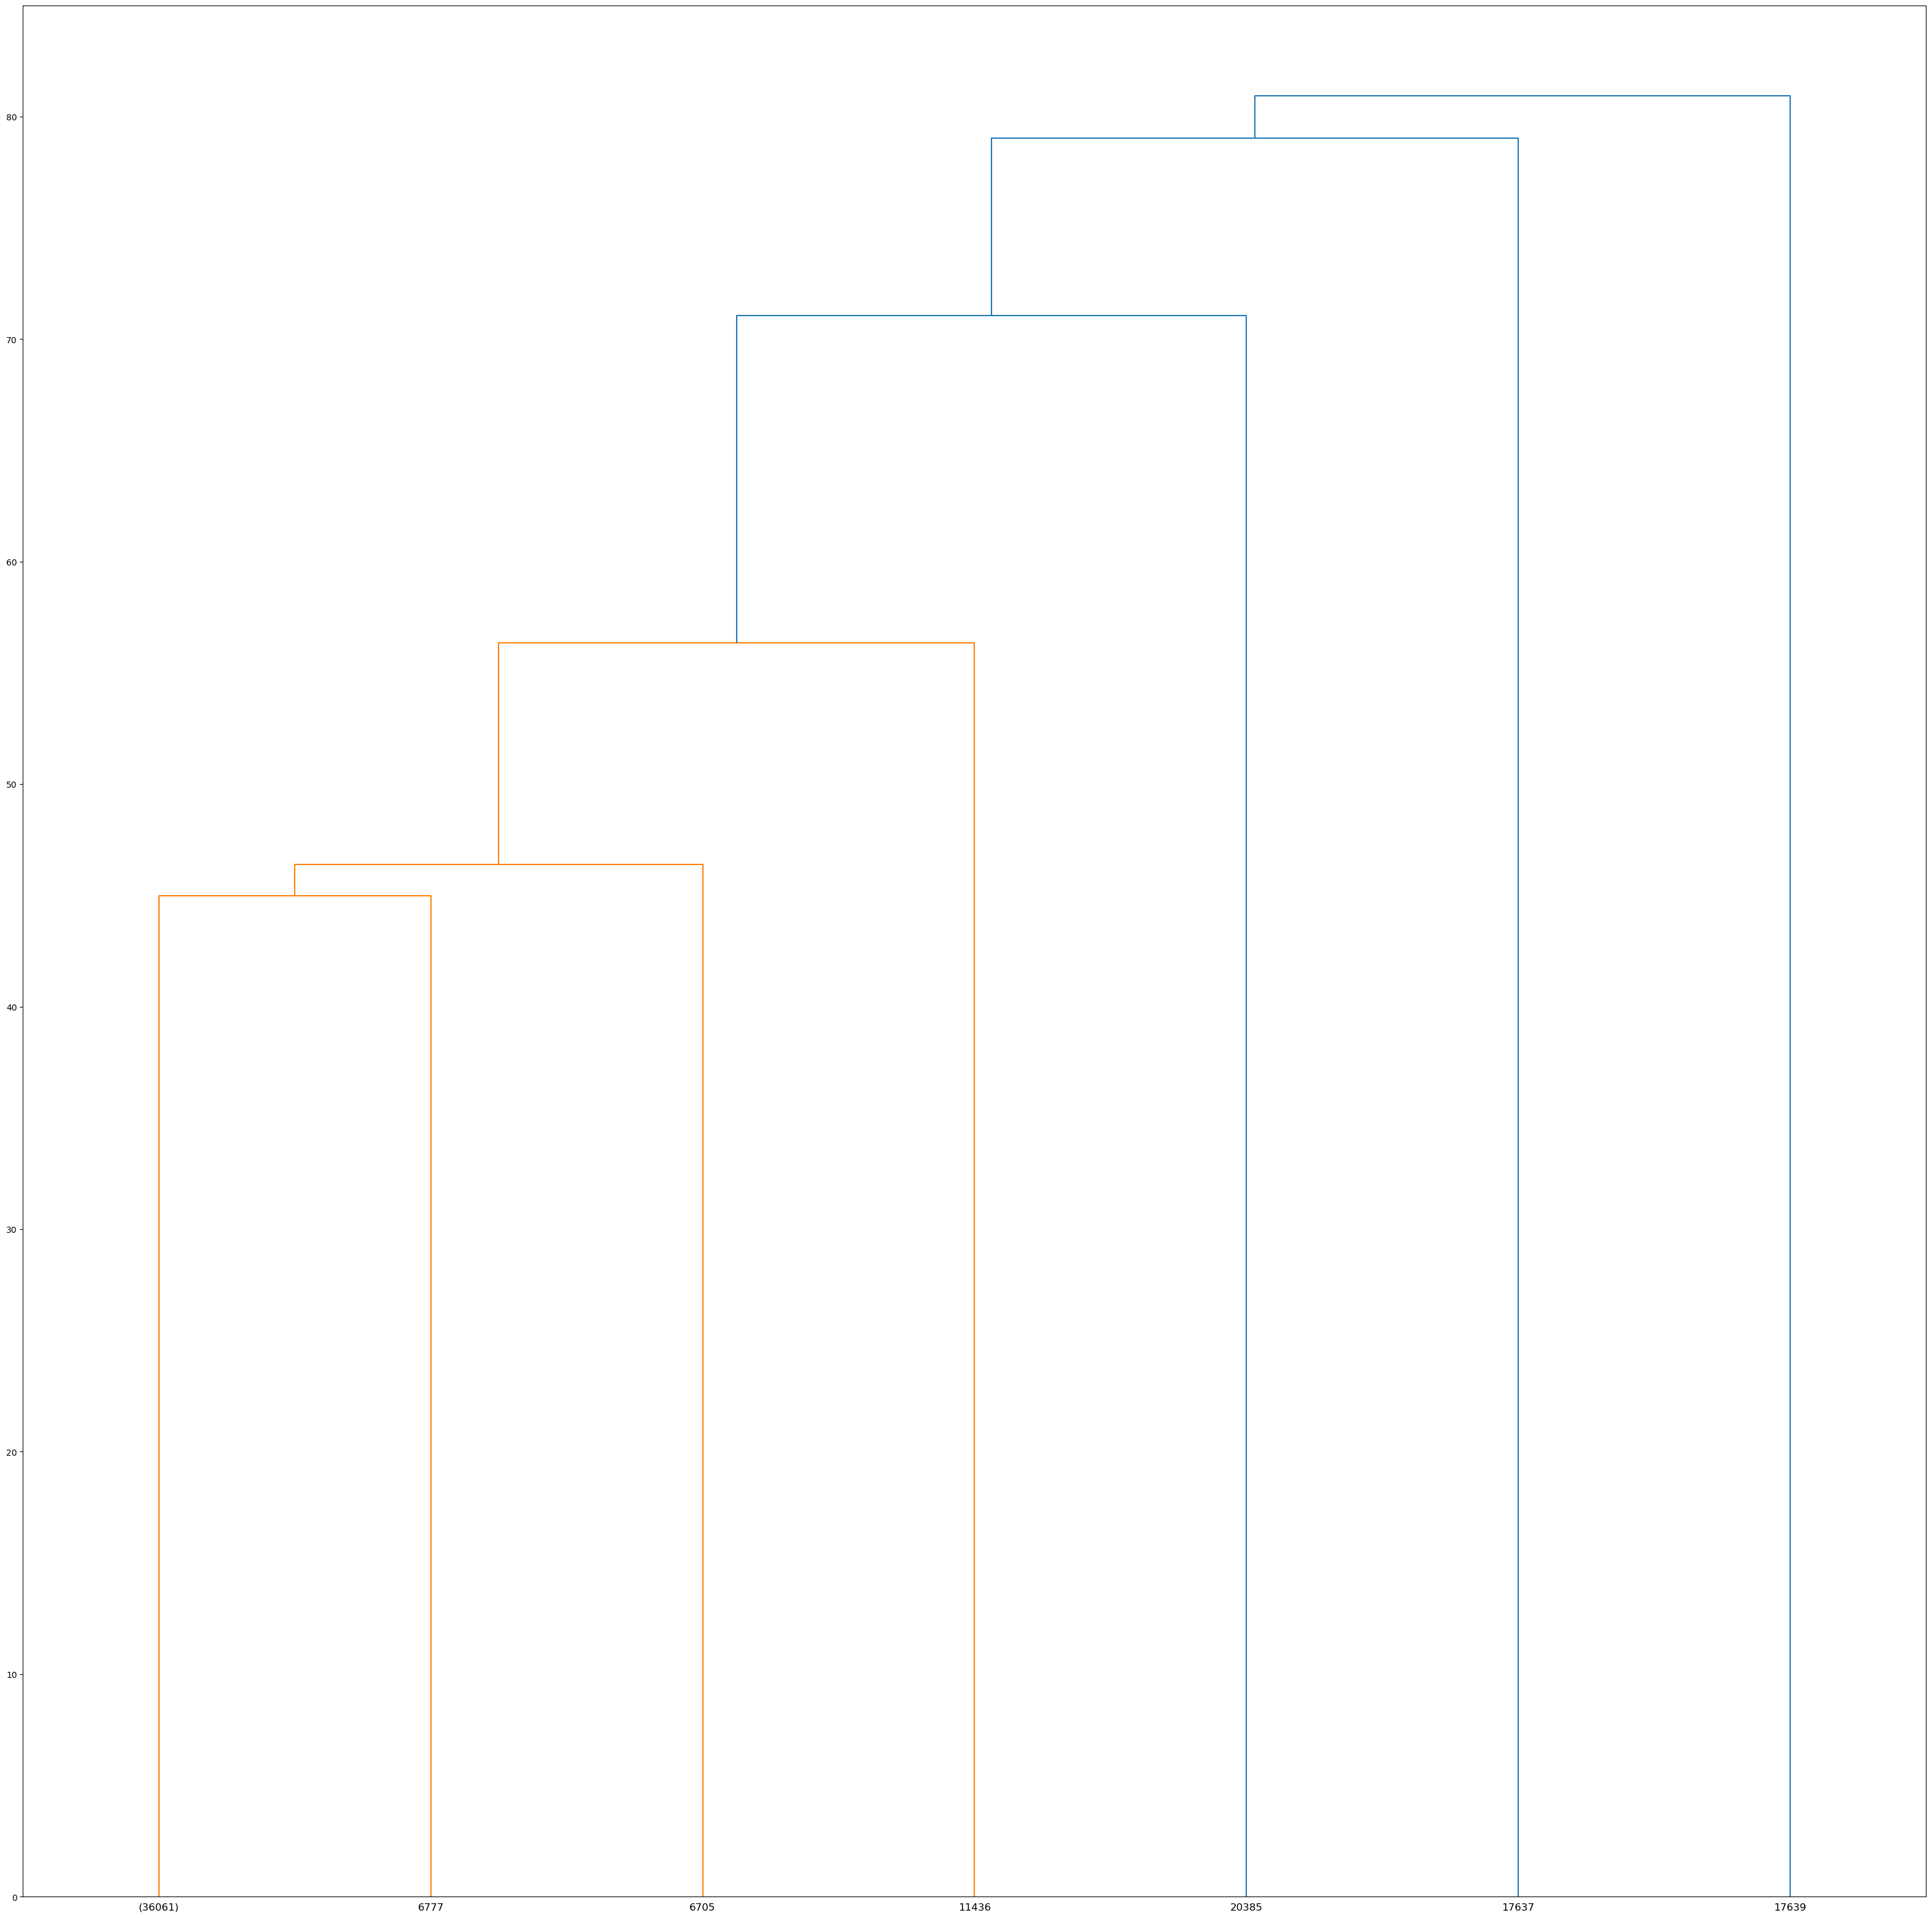

In [66]:
fix, ax = plt.subplots(figsize=(40,40))
# Plot the corresponding dendrogram
_ = dendrogram(linkage_tree, truncate_mode="level", p=5, ax=ax)

In [67]:
layer.get_fill_color = get_color(clusters)

### Visualise_clusters

In [57]:
from lonboard import PolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

In [58]:
plotting = tessellation.loc[X_train.index].copy().reset_index()

In [59]:
if 'uID' in plotting.columns:
    plotting['index'] = 'uID'

In [60]:
from core.cluster_validation import get_color

In [61]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", 'index']], opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [62]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = Map(layer, basemap_style=CartoBasemap.Positron)
with sc:
    display(m)

In [63]:
# clusters = cluster_layers[3]

In [64]:
clusters = fcluster(linkage_matrix, t=200, criterion='distance')

NameError: name 'linkage_matrix' is not defined

In [77]:
np.unique(clusters, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([  687,    80,  1573,   434,  3991,  1973, 20353,  2122,  1569,
         3285]))

In [78]:
layer.get_fill_color = get_color(clusters)

### Hierarchical

In [52]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

q1 = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
q1 = q1.higher_order(k=3, lower_order=True, diagonal=True)
clustering_graph = q1.subgraph(X_train.index.values).transform('B').sparse

In [65]:
%%time
clusterer = AgglomerativeClustering(linkage='ward',
                                    connectivity=clustering_graph, 
                                    compute_full_tree=True, compute_distances=True)
# model = clusterer.fit(embedding)

model = clusterer.fit(spatial_embedding)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 27 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


CPU times: user 14.5 s, sys: 5.73 s, total: 20.2 s
Wall time: 6.09 s


In [66]:
linkage_matrix = get_linkage_matrix(model)

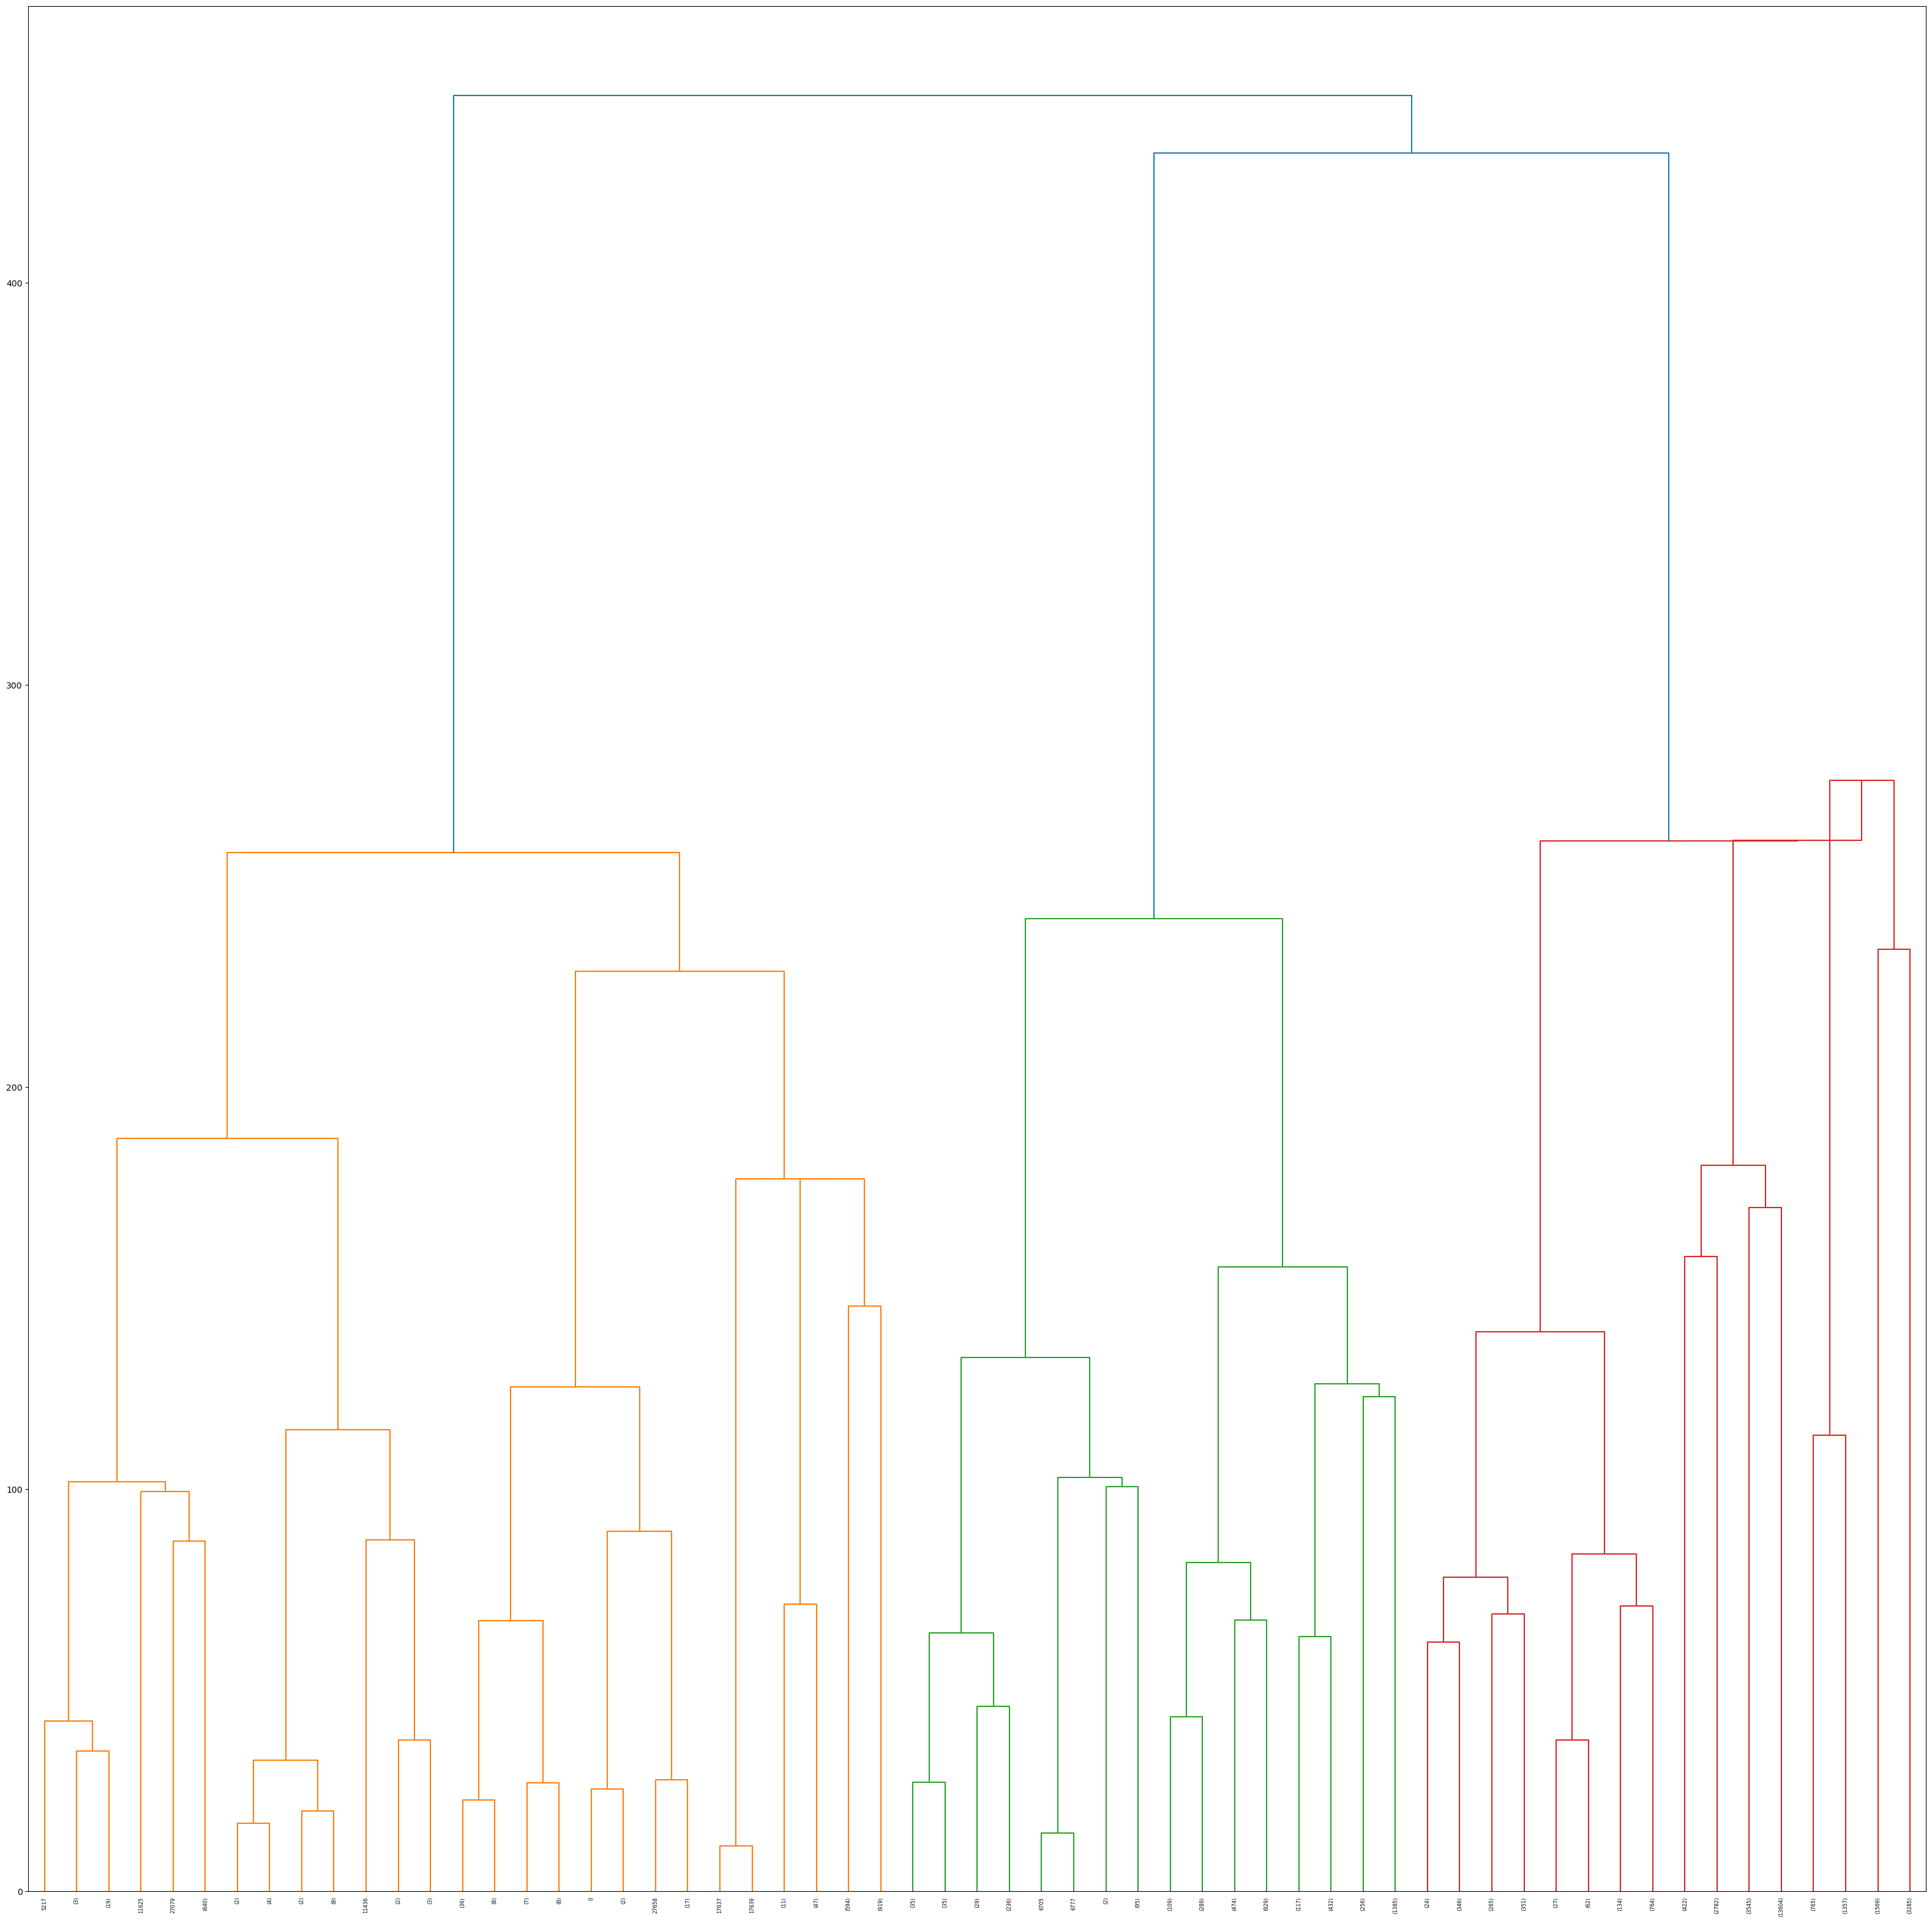

In [67]:
fix, ax = plt.subplots(figsize=(40,40))
# Plot the corresponding dendrogram
_ = dendrogram(linkage_matrix, truncate_mode="level", p=5, ax=ax)

In [70]:
for t in range(100, 4000, 100):
    r = fcluster(linkage_matrix, t=t, criterion='distance')
    # r = pd.Series(r, index=X_train.index)
    # # ssplits = graph.describe(r, statistics=['nunique'])['nunique']
    print(t, ' - ', 
          # adjusted_rand_score(tess_groups.values, r[tess_groups_ilocs]),
          # (ssplits > 1).sum() / ssplits.shape[0],
          davies_bouldin_score(X_train, r),
          calinski_harabasz_score(X_train, r)
         )

100  -  2.8990022398956383 431.2362460401442
200  -  3.3835602302651893 1027.2168729321397
300  -  2.595626752626742 1913.639278458374
400  -  2.595626752626742 1913.639278458374


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
# for t in range(1, 100, 5):
#     r = fcluster(linkage_matrix, t=t, criterion='distance')
#     # r = pd.Series(r, index=X_train.index)
#     # # ssplits = graph.describe(r, statistics=['nunique'])['nunique']
#     print(t, ' - ', 
#           # adjusted_rand_score(tess_groups.values, r[tess_groups_ilocs]),
#           # (ssplits > 1).sum() / ssplits.shape[0],
#           davies_bouldin_score(X_train, r),
#           calinski_harabasz_score(X_train, r)
#          )

In [ ]:
clusters = fcluster(linkage_matrix, t=51, criterion='distance')

In [69]:
from sklearn.metrics import calinski_harabasz_score

In [ ]:
# clusters = fcluster(np.load('../data/linkage_matrix.npy'), t=100, criterion='distance')

In [ ]:
from core.cluster_validation import colored_crosstab

In [ ]:
colored_crosstab(clusters[tess_groups_ilocs], tess_groups.values)

----

#### Graph construction

In [ ]:
# %%time
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from fast_hdbscan.numba_kdtree import parallel_tree_query

graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

from sklearn.neighbors import KDTree

sklearn_tree = KDTree(data)
numba_tree = kdtree_to_numba(sklearn_tree)
# result = parallel_tree_query(numba_tree, np.ascontiguousarray(data), k=n_neighbors)

# nn_dists, nn_inds = result

In [ ]:
# app_nn_inds, app_nn_dists = knn_graph(data, n_neighbors=n_neighbors)

In [ ]:
sigmas, rhos = smooth_knn_dist(
        nn_dists[:, 1:],
        float(n_neighbors),
    )

In [ ]:
np.allclose(rhos, nn_dists[:, 1])

In [ ]:
%%time


actual_dists, actual_knns = parallel_tree_query(numba_tree, np.ascontiguousarray(data[:5, :]), k=n_neighbors+1)

In [ ]:
actual_sigmas, actual_rhos = smooth_knn_dist(
        actual_dists[:, 1:],
        float(n_neighbors),
)

In [ ]:
actual_dists[:, 1], rhos[:5]

In [ ]:
sigmas[:5], actual_sigmas

In [ ]:
actual_knns[0], nn_inds[0]

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
np.allclose(cdist(X_train.iloc[[actual_knns[0, 0]]], X_train.iloc[actual_knns[0, 1:]])[0], actual_dists[0][1:])

In [ ]:
cdist(X_train.iloc[[nn_inds[0, 0]]], X_train.iloc[nn_inds[0, 1:]])[0], actual_dists[0][1:]

In [ ]:
rows, cols, vals = compute_membership_strengths(
        np.ascontiguousarray(nn_inds[:, 1:]), np.ascontiguousarray(nn_dists[:, 1:]), sigmas, rhos
)

In [ ]:
vals[:25]

In [ ]:
vs = compute_membership_strengths(
        np.ascontiguousarray(actual_knns[:, 1:]), np.ascontiguousarray(actual_dists[:, 1:]), actual_sigmas, actual_rhos
)[2]
vs[:25]

In [ ]:
smooth_knn_dist(
        nn_dists[:, 1:],
        float(n_neighbors),
    )

In [ ]:
# # r = pd.read_csv('https://figshare.com/ndownloader/files/31252825', compression='gzip')
# r = pd.read_csv('https://figshare.com/ndownloader/files/31250227', compression='gzip')
# r = r.drop([ 'mm_len', 'cdsbool', 'node_start', 'node_end', 'nID', 'nodeID', 'Unnamed: 0', 'bID',], axis=1).set_index('uID').sort_index()
# X_train.join(r).reset_index().to_parquet('../data/old_prague_data/old_prague_data.parquet')


import requests 
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
# download_url('https://figshare.com/ndownloader/files/31252828', '../data/old_prague_geometries.zip') 
# import zipfile
# z = zipfile.ZipFile('../data/old_prague_geometries.zip')
# z.extractall("../data/old_prague_geometries/")



In [ ]:
# download_url('https://drive.usercontent.google.com/u/0/uc?id=1oxRyqW_dOVbosa19zigELrD3J-oOdUlk&export=download',
#              )

In [6]:
gdf = gpd.read_file('../data/old_prague_data/prg_geometry.gpkg')
gdf

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in 'prg_geometry.gpkg': 'buildings' (default), 'nodes', 'edges', 'tessellation', 'blocks'. Specify layer parameter to avoid this warning.
  result = read_func(


,uID,geometry
0,0,"POLYGON ((-749844.585 -1052277.805, -749844.41..."
1,1,"POLYGON ((-744449.58 -1042702.59, -744447.15 -..."
2,2,"POLYGON ((-733304.06 -1048133.18, -733299.931 ..."
3,3,"POLYGON ((-742471.51 -1039697.12, -742472.27 -..."
4,4,"POLYGON ((-740088.94 -1043853.95, -740089.1 -1..."
...,...,...
140403,140457,"POLYGON ((-742306.21 -1043656.25, -742334.11 -..."
140404,140458,"POLYGON ((-745118.15 -1036872.01, -745120.66 -..."
140405,140459,"POLYGON ((-741493.72 -1045901.36, -741493.82 -..."
140406,140460,"POLYGON ((-741505.02 -1045901.01, -741505.419 ..."
